# Model Building

In [1]:
import os.path
import pandas as pd
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, \
    hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC
import pickle

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
DATA_DIR = os.path.join("tree_FINAL")
tree_dataset = pd.read_csv(DATA_DIR, index_col=0)
pd.set_option('display.max_columns', 1000)

In [3]:
#drop the columns i used for EDA
tree_dataset.drop(['soil_type', 'WA_type'], axis=1, inplace=True)

In [4]:
tree_dataset.Tree_Type.value_counts()

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Tree_Type, dtype: int64

# Hold out test set (tree_data_test)

In [5]:
from sklearn.model_selection import train_test_split

tree_data, tree_data_test = train_test_split(tree_dataset, test_size=0.2, random_state=1)

In [6]:
#our hold hold out test set features and response variable

tree_features = tree_data_test.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]]
tree_class = tree_data_test.Tree_Type

In [7]:
# training data

tree_data.Tree_Type.value_counts()

6    1749
5    1742
7    1741
1    1726
3    1723
4    1713
2    1702
Name: Tree_Type, dtype: int64

# Selecting my training predictor and response variables

In [8]:
X_train = tree_data.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]]
y_train = tree_data.Tree_Type

# Model - Naive Bayes

In [9]:
# training a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)

In [10]:
#cross val score
from sklearn.model_selection import cross_val_score
gnb_cv_score = cross_val_score(gnb, X_train, y_train, cv=5).mean()
gnb_cv_score

0.5864788660852629

In [11]:
#test holdout set 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


tree_class_pred = gnb.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)
#accuracy_score(tree_class_pred, tree_class)

0.59689153439153442

In [12]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.51      0.75      0.61       434
          2       0.67      0.14      0.23       458
          3       0.44      0.76      0.56       437
          4       0.73      0.93      0.81       447
          5       0.56      0.70      0.62       418
          6       0.83      0.07      0.13       411
          7       0.86      0.83      0.84       419

avg / total       0.65      0.60      0.54      3024



# Model - KNN

**optimizing parameters**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Define the parameter values that should be searched
leaf_size_range = [1,5,10, 20, 30, 40]
n_neighbors_range=[1,5,10, 20, 30, 40]



# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(leaf_size=leaf_size_range, n_neighbors=n_neighbors_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

{'leaf_size': [1, 5, 10, 20, 30, 40], 'n_neighbors': [1, 5, 10, 20, 30, 40]}
Best parameters set found on development set:

{'leaf_size': 1, 'n_neighbors': 1}


In [15]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=1)
knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [16]:
knn_cv_score = cross_val_score(knn, X_train, y_train, cv=5).mean()
knn_cv_score

0.83192981636374896

In [17]:
#tried Normalizing my data.. made the model worse. 

In [18]:
tree_class_pred = knn.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.83333333333333337

In [19]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.74      0.66      0.70       434
          2       0.72      0.64      0.67       458
          3       0.84      0.81      0.83       437
          4       0.91      0.95      0.93       447
          5       0.88      0.97      0.92       418
          6       0.83      0.87      0.85       411
          7       0.88      0.95      0.92       419

avg / total       0.83      0.83      0.83      3024



# Model - SVM ("One Vs Rest" scikit built-in)

**base - not optimized**

In [20]:
#create pipeline
pipe = Pipeline([('scale', StandardScaler(with_mean=True, with_std=True)), ('svm', SVC(decision_function_shape='ovr'))])
#set param_grid
param_grid = {'svm__C':[1, 2]}
#grid search through the parameters 
grid = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True)
#fit it to my data 
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1, param_grid={'svm__C': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [21]:
base_svc_cv_score = cross_val_score(grid, X_train, y_train, cv=5).mean()
base_svc_cv_score

0.74636404130220002

In [22]:
tree_class_pred = grid.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.7589285714285714

In [23]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.67      0.69      0.68       434
          2       0.67      0.57      0.62       458
          3       0.73      0.65      0.69       437
          4       0.84      0.95      0.89       447
          5       0.80      0.84      0.82       418
          6       0.69      0.74      0.71       411
          7       0.90      0.88      0.89       419

avg / total       0.76      0.76      0.76      3024



**optimized**

In [24]:
#create pipeline
pipe = Pipeline([('scale', StandardScaler(with_mean=True, with_std=True)), ('svm', SVC(decision_function_shape='ovr'))])
#set param_grid
param_grid = {'svm__C':[10, 15, 20, 30], 'svm__gamma':[0.01, 0.05, 0.1, 0.25, 0.5]}
#grid search through the parameters 
grid_ovr = GridSearchCV(pipe, cv=3, param_grid=param_grid, scoring='accuracy', refit=True)
#fit it to my data 
grid_ovr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': [10, 15, 20, 30], 'svm__gamma': [0.01, 0.05, 0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [25]:
grid_ovr.best_params_

{'svm__C': 10, 'svm__gamma': 0.25}

In [26]:
grid_ovr_cv_score = cross_val_score(grid_ovr, X_train, y_train, cv=5).mean()
grid_ovr_cv_score

0.82200592604896561

In [27]:
tree_class_pred = grid_ovr.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.83796296296296291

In [28]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.73      0.74      0.74       434
          2       0.76      0.64      0.70       458
          3       0.82      0.78      0.80       437
          4       0.94      0.95      0.95       447
          5       0.87      0.95      0.91       418
          6       0.80      0.87      0.83       411
          7       0.93      0.95      0.94       419

avg / total       0.84      0.84      0.84      3024



# Model - SVM ("One Vs. Rest" manually)

**separate file - in this folder - named "svm_manual"**

# Model - DecisionTree Classifier 

**base - not optimized**

In [29]:
#no need to scale for decision trees

In [30]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [31]:
decision_tree_cv_score = cross_val_score(decision_tree, X_train, y_train, cv=5).mean()
decision_tree_cv_score

0.7657925565267395

In [32]:
tree_class_pred = decision_tree.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.79927248677248675

In [33]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.67      0.66      0.66       434
          2       0.66      0.62      0.64       458
          3       0.78      0.77      0.77       437
          4       0.95      0.95      0.95       447
          5       0.86      0.89      0.87       418
          6       0.78      0.81      0.80       411
          7       0.89      0.91      0.90       419

avg / total       0.80      0.80      0.80      3024



In [34]:
#just using a base decision tree does not give me a better model that SVM

**optimized**

In [35]:
# Define the parameter values that should be searched
max_depth_range = [1e-4, 1e-3, 1.5e-3, 1e-2, 1.5e-2, 1e-1, 1, 5, 10, 50, 100, 1000, 10000, 100000]
min_samples_split_range = [0.5, 2, 5, 10]
min_samples_leaf_range = [0.1, 1, 2, 3, 4, 5, 10]


# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(max_depth=max_depth_range, min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

{'max_depth': [0.0001, 0.001, 0.0015, 0.01, 0.015, 0.1, 1, 5, 10, 50, 100, 1000, 10000, 100000], 'min_samples_split': [0.5, 2, 5, 10], 'min_samples_leaf': [0.1, 1, 2, 3, 4, 5, 10]}
Best parameters set found on development set:

{'max_depth': 100000, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [36]:
decision_tree2 = DecisionTreeClassifier(max_depth=100, random_state=0, min_samples_leaf =1, min_samples_split = 2)
decision_tree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [37]:
decision_tree2_cv_score = cross_val_score(decision_tree2, X_train, y_train, cv=5).mean()
decision_tree2_cv_score

0.7657925565267395

In [38]:
#test on holdout set
tree_class_pred = decision_tree2.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.79927248677248675

In [39]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.67      0.66      0.66       434
          2       0.66      0.62      0.64       458
          3       0.78      0.77      0.77       437
          4       0.95      0.95      0.95       447
          5       0.86      0.89      0.87       418
          6       0.78      0.81      0.80       411
          7       0.89      0.91      0.90       419

avg / total       0.80      0.80      0.80      3024



In [40]:
#no difference... look at other algorithims

# Model - Extra Trees Classifier 

In [41]:
from sklearn.ensemble import ExtraTreesClassifier

**base - not optimized**

In [42]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
etc_cv_score = cross_val_score(etc, X_train, y_train, cv=5).mean()
etc_cv_score

0.82068326930495361

In [44]:
tree_class_pred = etc.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.84424603174603174

In [45]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.73      0.75      0.74       434
          2       0.75      0.69      0.72       458
          3       0.83      0.83      0.83       437
          4       0.96      0.97      0.96       447
          5       0.90      0.89      0.90       418
          6       0.83      0.85      0.84       411
          7       0.91      0.94      0.92       419

avg / total       0.84      0.84      0.84      3024



**optimized**

In [ ]:
# Define the parameter values that should be searched
bootstrap_range = [True, False]
max_features_range = ['auto', 'sqrt', 'log2', None]
min_samples_split_range = [0.5, 2, 3, 5, 10]
min_samples_leaf_range = [0.1, 1, 2, 3, 4, 5, 10]
n_jobs_range = [1,2,3,4,5]


# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(bootstrap=bootstrap_range, min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range, n_jobs=n_jobs_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

In [46]:
extra_tree = ExtraTreesClassifier(n_jobs = 5, random_state=1234)
extra_tree.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [47]:
extra_tree_cv_score = cross_val_score(extra_tree, X_train, y_train, cv=5).mean()
extra_tree_cv_score

0.82399366990413392

In [48]:
tree_class_pred = extra_tree.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.84457671957671954

In [49]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.75      0.74      0.75       434
          2       0.76      0.66      0.71       458
          3       0.82      0.84      0.83       437
          4       0.95      0.97      0.96       447
          5       0.86      0.91      0.89       418
          6       0.86      0.84      0.85       411
          7       0.91      0.95      0.93       419

avg / total       0.84      0.84      0.84      3024



# Model - Random Forest Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

**base - not optimized**

In [51]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
rf_cv_score = cross_val_score(rf, X_train, y_train, cv=5).mean()
rf_cv_score

0.81572363260445402

In [53]:
#test on holdout set
tree_class_pred = rf.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.83498677248677244

In [54]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.69      0.72      0.70       434
          2       0.73      0.62      0.67       458
          3       0.83      0.85      0.84       437
          4       0.95      0.96      0.96       447
          5       0.89      0.91      0.90       418
          6       0.85      0.85      0.85       411
          7       0.90      0.94      0.92       419

avg / total       0.83      0.83      0.83      3024



**optimized**

In [55]:
# Define the parameter values that should be searched
bootstrap_range = [True, False]
max_features_range = [1, 10, 20, 30, 40, 50, 51, 52]
n_estimators_range = [1, 7, 8, 9, 10, 20, 30, 40, 50, 100]

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(bootstrap=bootstrap_range, max_features=max_features_range, n_estimators=n_estimators_range)
print(param_grid)

# Instantiate the grid
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

# View best parameter
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

{'bootstrap': [True, False], 'max_features': [1, 10, 20, 30, 40, 50, 51, 52], 'n_estimators': [1, 7, 8, 9, 10, 20, 30, 40, 50, 100]}
Best parameters set found on development set:

{'bootstrap': False, 'max_features': 20, 'n_estimators': 100}


In [56]:
rf5 = RandomForestClassifier(bootstrap=False, max_features=20, n_estimators=100)
rf5.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=20, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
cross_val_score(rf5, X_train, y_train, cv=5).mean()

0.86185353023226396

In [58]:
#test on holdout
tree_class_pred = rf5.predict(tree_features)
accuracy_score(tree_class, tree_class_pred)

0.87136243386243384

In [59]:
print(classification_report(tree_class, tree_class_pred))

             precision    recall  f1-score   support

          1       0.78      0.74      0.76       434
          2       0.79      0.71      0.75       458
          3       0.89      0.85      0.87       437
          4       0.95      0.98      0.96       447
          5       0.90      0.94      0.92       418
          6       0.86      0.93      0.89       411
          7       0.91      0.96      0.93       419

avg / total       0.87      0.87      0.87      3024



# My best model! 

# Best Model Analysis - Random Forest Classifier

**Most important features**

In [60]:
feature_importances = pd.DataFrame(rf5.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
top10_features = feature_importances.head(5)

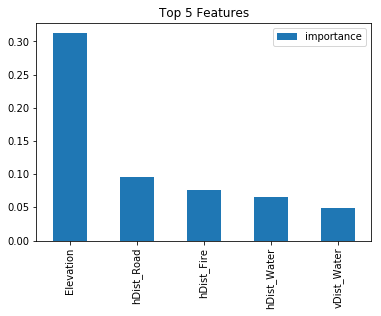

In [61]:
%matplotlib inline
top10_features.plot(kind='bar', title='Top 5 Features')

**learning curve**

Automatically created module for IPython interactive environment


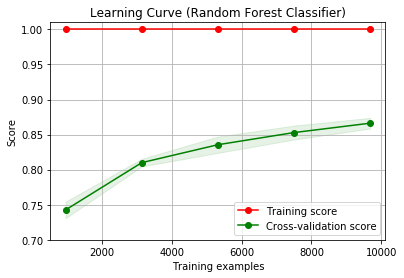

In [62]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
  
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



title = "Learning Curve (Random Forest Classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plot_learning_curve(rf5, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=1)

plt.savefig('Learning Curve')
plt.show()